In [1]:
import os
import numpy as np
import matplotlib.image as mpimg
import tensorflow as tf
import skimage as ski
from tensorflow.keras.layers import Input, Conv2D, Dropout
from tensorflow.keras.models import Model
from skimage.transform import resize
#!pip install scikit-image



In [2]:
def load_dataset(image_dir, gt_dir, target_size=(256, 256)):
    image_files = sorted([f for f in os.listdir(image_dir) if not f.startswith('.')])
    gt_files = sorted([f for f in os.listdir(gt_dir) if not f.startswith('.')])
    
    images = [resize(mpimg.imread(os.path.join(image_dir, fname)), target_size) for fname in image_files]
    annotations = [resize(mpimg.imread(os.path.join(gt_dir, fname)), target_size) for fname in gt_files]
    
    # Ensure 3 channels for all images
    images = [img[:, :, :3] if img.shape[2] > 3 else img for img in images]
    
    images = [img.astype(np.float32) / 255.0 if img.dtype == np.uint8 else img for img in images]
    
    return images, annotations


def convert_rgba_to_binary_mask(annotations):
    binary_masks = [np.where(annotation[:, :, 0] > 0.5, 1, 0) for annotation in annotations]
    return binary_masks


In [3]:
TRAIN_IMAGE_DIR = "Data/Training/Images"
TRAIN_GT_DIR = "Data/Training/GT"
TEST_IMAGE_DIR = "Data/Testing/Images"
TEST_GT_DIR = "Data/Testing/GT"

train_images, train_annotations = load_dataset(TRAIN_IMAGE_DIR, TRAIN_GT_DIR)
train_masks = convert_rgba_to_binary_mask(train_annotations)
test_images, test_annotations = load_dataset(TEST_IMAGE_DIR, TEST_GT_DIR)
test_masks = convert_rgba_to_binary_mask(test_annotations)


In [4]:
def create_deeplabv3plus(input_shape):
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, alpha=1.0)
    base_model.trainable = True
    
    # Use the features from the out_relu layer
    x = base_model.get_layer('out_relu').output
    
    # Decoder with upsampling and convolutional layers
    x = tf.keras.layers.UpSampling2D((2, 2))(x)  # Upsample to 16x16
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Dropout(0.5)(x)
    
    x = tf.keras.layers.UpSampling2D((2, 2))(x)  # Upsample to 32x32
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Dropout(0.5)(x)

    x = tf.keras.layers.UpSampling2D((2, 2))(x)  # Upsample to 64x64
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Dropout(0.5)(x)
    
    x = tf.keras.layers.UpSampling2D((2, 2))(x)  # Upsample to 128x128
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Dropout(0.5)(x)

    x = tf.keras.layers.UpSampling2D((2, 2))(x)  # Upsample to 256x256
    x = Conv2D(1, (1, 1), activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    
    return model



In [5]:
# Commenting Model Building as Model is already saved as 'model1.h5'
'''
model = create_deeplabv3plus((256, 256, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(np.array(train_images), np.array(train_masks), batch_size=16, epochs=10, validation_split=0.2)
'''


"\nmodel = create_deeplabv3plus((256, 256, 3))\nmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])\nhistory = model.fit(np.array(train_images), np.array(train_masks), batch_size=16, epochs=10, validation_split=0.2)\n"

In [6]:
# Commenting as model already saved, to prevent re-write
'''
# Specify the path where you want to save the model
model1= "model1.h5"

# Save the model
model.save(model1)
'''

'\n# Specify the path where you want to save the model\nmodel1= "model1.h5"\n\n# Save the model\nmodel.save(model1)\n'

In [7]:
from tensorflow.keras.models import load_model

# Specify the path where the model was saved
model1 = "model1.h5"

# Load the model
model = load_model(model1)



In [8]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('model1.h5')

# Print the model's architecture
model.summary()

# Access the configuration of a particular layer
for layer in model.layers:
    print(layer.get_config())

# Access the weights of a particular layer
for layer in model.layers:
    weights = layer.get_weights()  # returns a list of all weight arrays
    print(weights)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 128, 32)         864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 128, 128, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 128, 128, 32)         0         ['bn_Conv1[0][0]']      

11/11 [==============================] - 34s 3s/step - loss: 1.4637 - accuracy: 0.8402
Test Loss: 1.4637
Test Accuracy: 0.8402


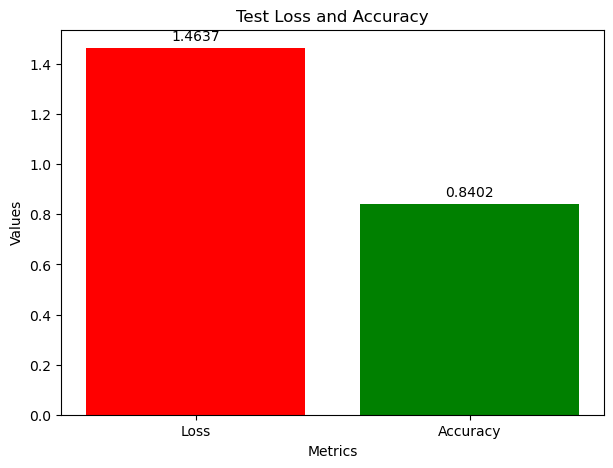

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the test_images and test_masks as numpy arrays
test_images = np.array(test_images)
test_masks = np.array(test_masks)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_images, test_masks)

# Print out the loss and accuracy
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Create bar plot for loss and accuracy
metrics = ['Loss', 'Accuracy']
values = [loss, accuracy]

plt.figure(figsize=(7, 5))
plt.bar(metrics, values, color=['red', 'green'])
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Test Loss and Accuracy')
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', va='bottom')

plt.show()


1/1 [==============================] - 2s 2s/step


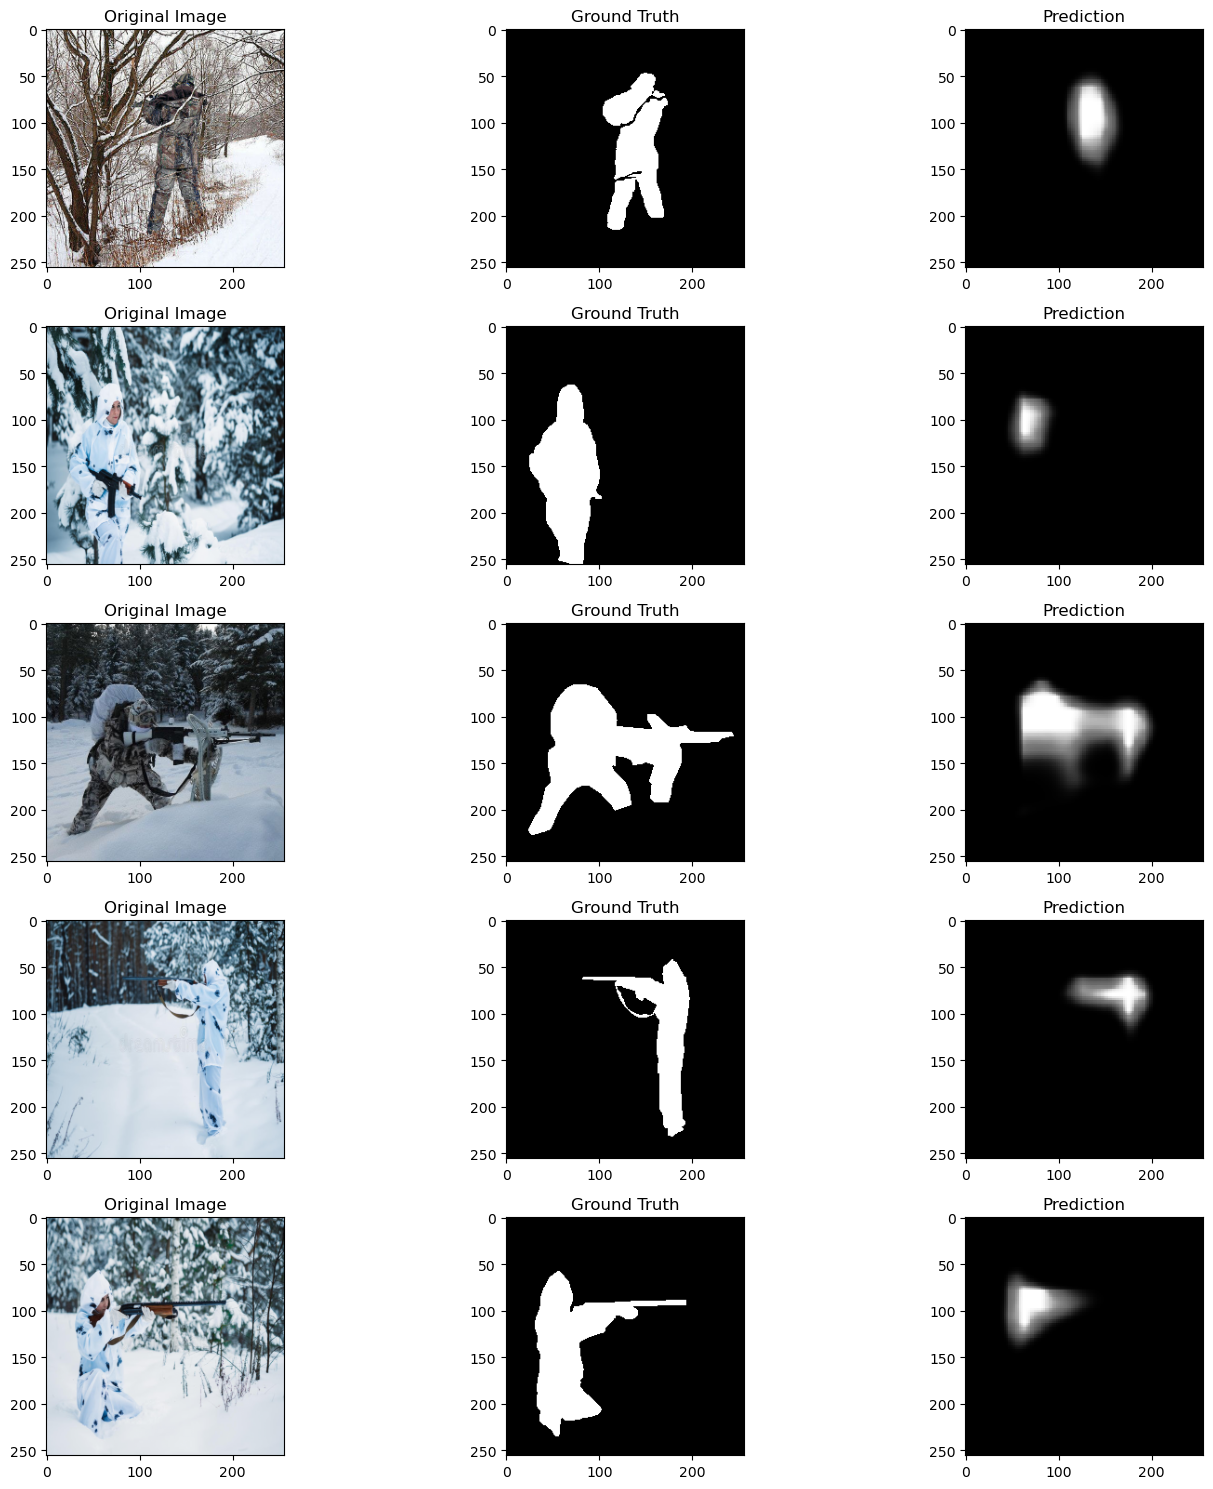

In [16]:
import matplotlib.pyplot as plt

# Predict on a subset of the test dataset
num_samples = 5
predictions = model.predict(np.array(test_images[:num_samples]))

# Display the test images, ground truth masks, and predicted masks
fig, axes = plt.subplots(num_samples, 3, figsize=(15, 15))

for i in range(num_samples):
    axes[i, 0].imshow(test_images[i])
    axes[i, 0].set_title('Original Image')
    
    axes[i, 1].imshow(test_masks[i], cmap='gray')
    axes[i, 1].set_title('Ground Truth')
    
    axes[i, 2].imshow(predictions[i].squeeze(), cmap='gray')
    axes[i, 2].set_title('Prediction')

plt.tight_layout()
plt.show()


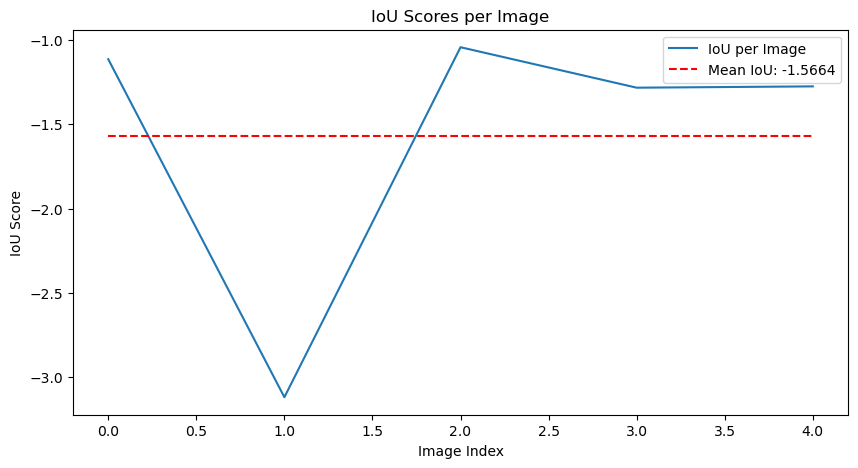

Mean IOU of the select images:  -1.5663513765148998


In [18]:
def compute_iou(y_true, y_pred):
    # Convert prediction to binary format based on a threshold (e.g., 0.5)
    y_pred = (y_pred > 0.5).astype(np.uint8)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    iou = intersection / union if union != 0 else 0  # Avoid division by zero
    return iou

# Compute IoU for each pair of true mask and predicted mask
ious = [compute_iou(true_mask, pred_mask) for true_mask, pred_mask in zip(test_masks, predictions)]

# Calculate the mean IoU across all images
mean_iou = np.mean(ious)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(ious, label='IoU per Image')
plt.hlines(mean_iou, 0, len(ious)-1, colors='red', linestyles='dashed', label=f'Mean IoU: {mean_iou:.4f}')
plt.xlabel('Image Index')
plt.ylabel('IoU Score')
plt.title('IoU Scores per Image')
plt.legend()
plt.show()

print('Mean IOU of the select images: ',mean_iou)


1/1 [==============================] - 1s 1s/step


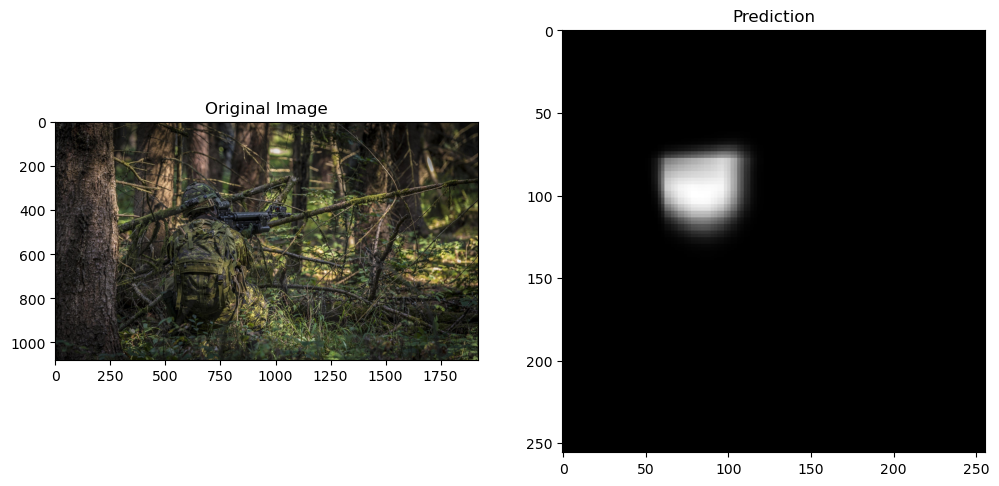

1/1 [==============================] - 0s 224ms/step


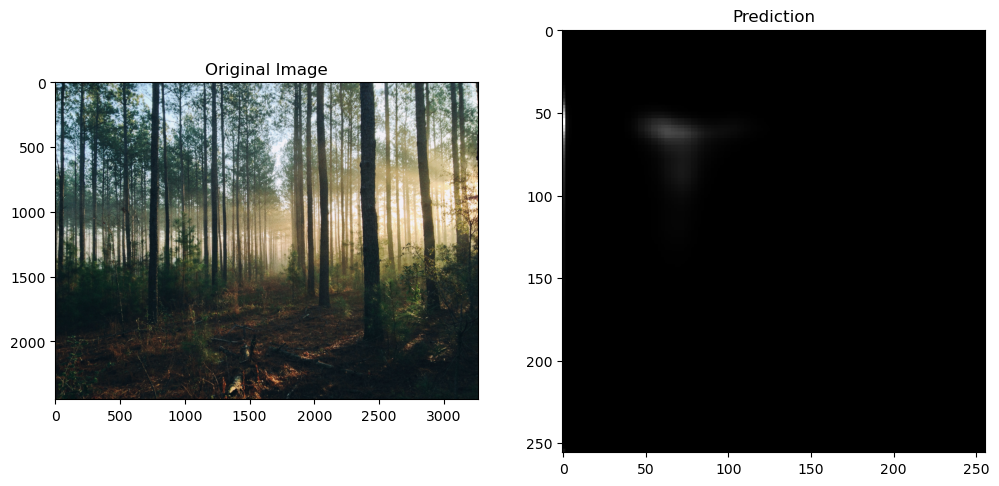

1/1 [==============================] - 0s 220ms/step


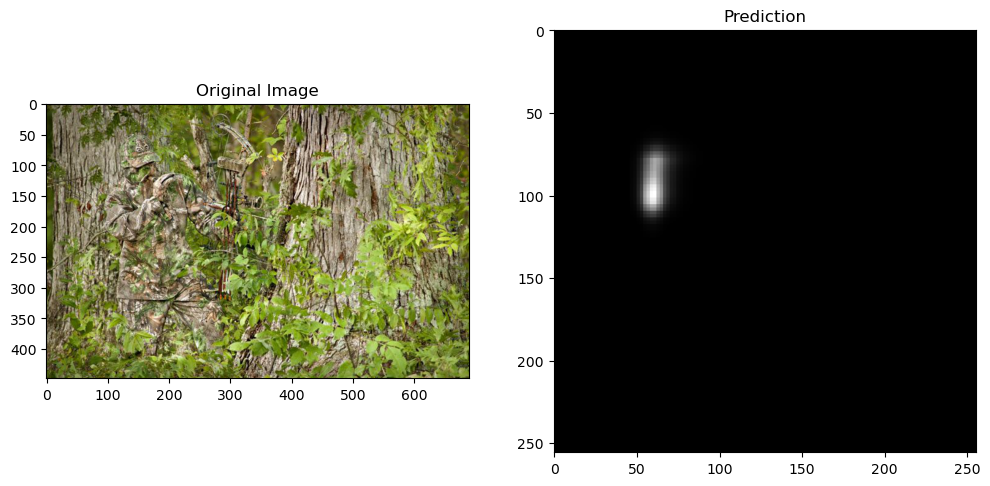

1/1 [==============================] - 0s 222ms/step


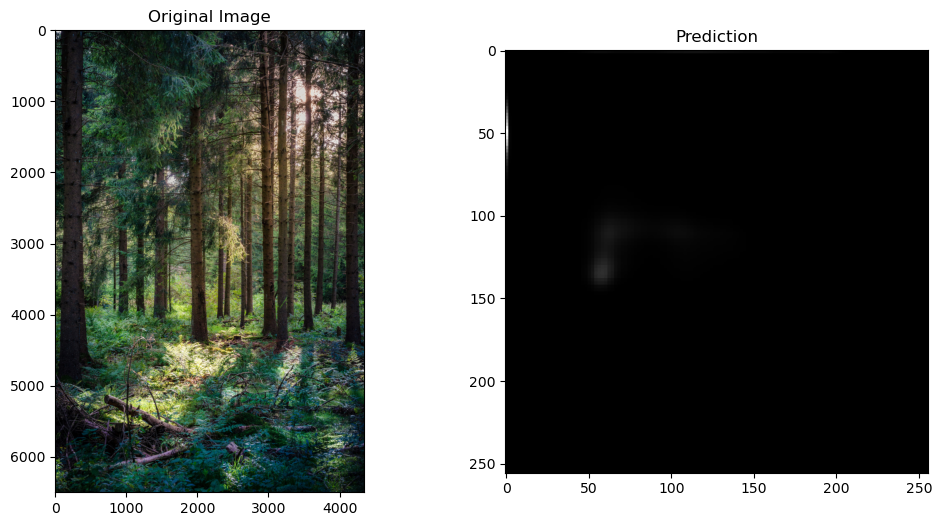

1/1 [==============================] - 0s 247ms/step


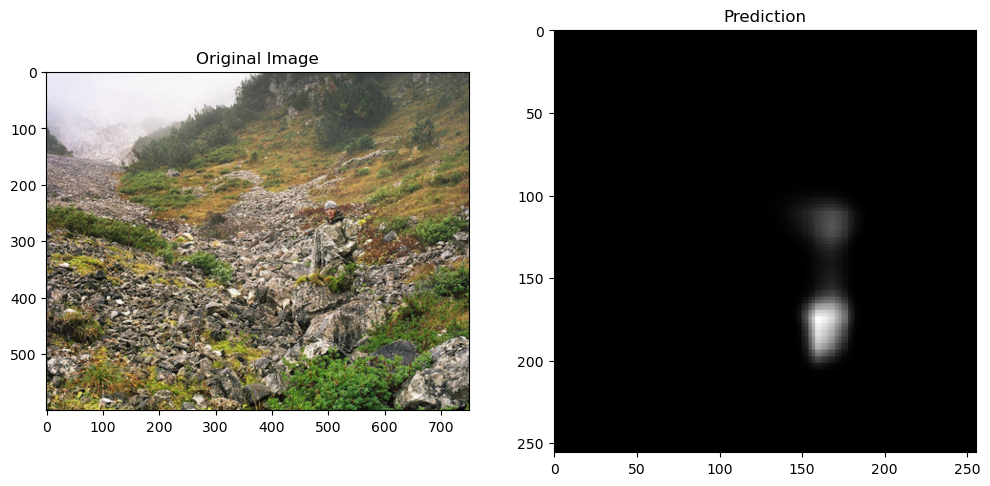

1/1 [==============================] - 0s 250ms/step


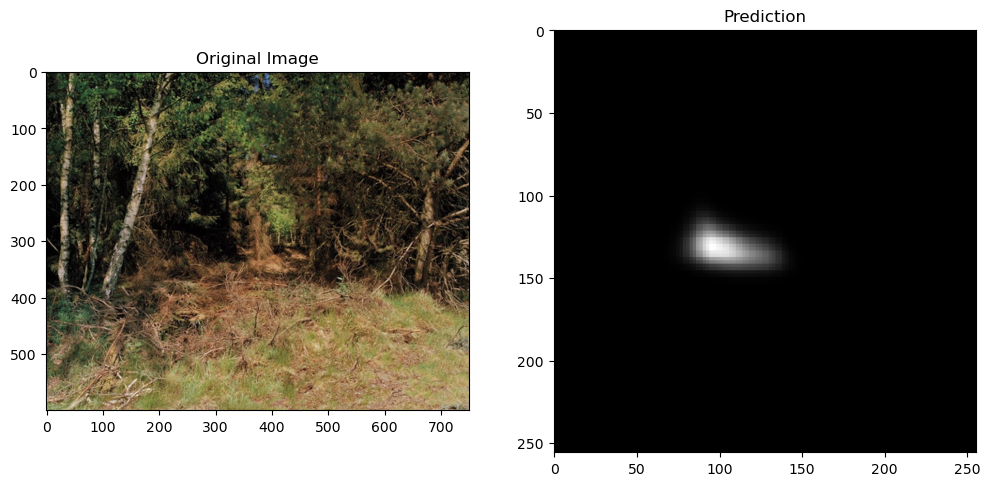

1/1 [==============================] - 0s 235ms/step


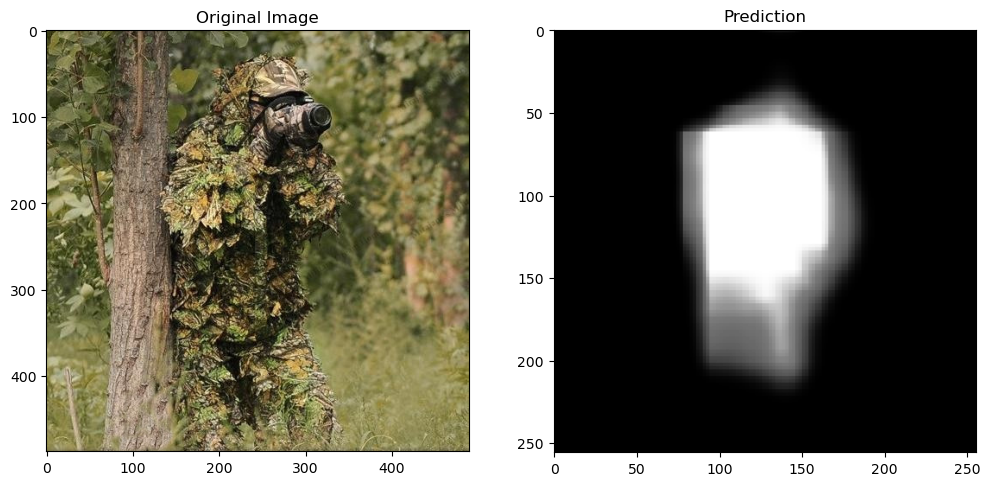

1/1 [==============================] - 0s 240ms/step


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.transform import resize
import os  # To list directory contents

# Define the path to the saved model and the directory containing images
model_path = 'model1.h5'  # Replace with your actual model path if different
image_dir = 'Trial'  # Replace with your actual image directory if different

# Load the trained model
model = tf.keras.models.load_model(model_path)

# Function to load and preprocess a single image
def load_and_preprocess_image(image_path):
    input_image = load_img(image_path, target_size=(256, 256))  # Resize to the input size expected by the model
    input_image = img_to_array(input_image)  # Convert to array
    input_image = np.expand_dims(input_image, axis=0)  # Add batch dimension
    input_image = input_image / 255.0  # Scale pixel values to [0, 1]
    return input_image

# Iterate over all images in the directory
for filename in os.listdir(image_dir):
    # Construct the full path to the image
    file_path = os.path.join(image_dir, filename)
    if os.path.isfile(file_path):
        # Load and preprocess the image
        input_image = load_and_preprocess_image(file_path)
        
        # Predict using the model
        predictions = model.predict(input_image)
        
        # Visualize the image and the prediction
        plt.figure(figsize=(12, 6))

        # Show the original image
        original_image = plt.imread(file_path)
        plt.subplot(1, 2, 1)
        plt.imshow(original_image)
        plt.title('Original Image')

        # Show the prediction (assuming single-channel output)
        # Adjust this if your prediction includes more channels or is not image-like
        plt.subplot(1, 2, 2)
        plt.imshow(predictions[0, :, :, 0], cmap='gray')
        plt.title('Prediction')

        # Display the plot
        plt.show()


In [13]:
import gradio as gr
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO

# Load the trained model
model = load_model('model1.h5')  # Make sure 'model1.h5' is the correct path to your model

# Prediction function for the Gradio app
def predict_and_visualize(img):
    # Store the original image size
    original_size = img.size
    
    # Convert the input image to the target size expected by the model
    img_resized = img.resize((256, 256))
    img_array = np.array(img_resized) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make a prediction
    prediction = model.predict(img_array)
    
    # Assuming the model outputs a single-channel image, normalize to 0-255 range for display
    predicted_mask = (prediction[0, :, :, 0] * 255).astype(np.uint8)
    
    # Convert the prediction to a PIL image
    prediction_image = Image.fromarray(predicted_mask, mode='L')  # 'L' mode is for grayscale
    
    # Resize the predicted image back to the original image size
    prediction_image = prediction_image.resize(original_size, Image.NEAREST)

    return prediction_image

# Create the Gradio interface
iface = gr.Interface(
    fn=predict_and_visualize,
    inputs=gr.Image(type="pil"),  # We expect a PIL Image
    outputs=gr.Image(type="pil"),  # We will return a PIL Image
    title="MilitarEye: Military Camouflage Detection",
    description="Upload an image to see the model's predicted probable camouflage mask position."
)

# Launch the Gradio app
iface.launch()


c:\Users\alias\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
